In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv("../data/fraud.csv")
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


In [3]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11142 entries, 0 to 11141
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            11142 non-null  int64  
 1   type            11142 non-null  object 
 2   amount          11142 non-null  float64
 3   nameOrig        11142 non-null  object 
 4   oldbalanceOrg   11142 non-null  float64
 5   newbalanceOrig  11142 non-null  float64
 6   nameDest        11142 non-null  object 
 7   oldbalanceDest  11142 non-null  float64
 8   newbalanceDest  11142 non-null  float64
 9   isFraud         11142 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 870.6+ KB


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

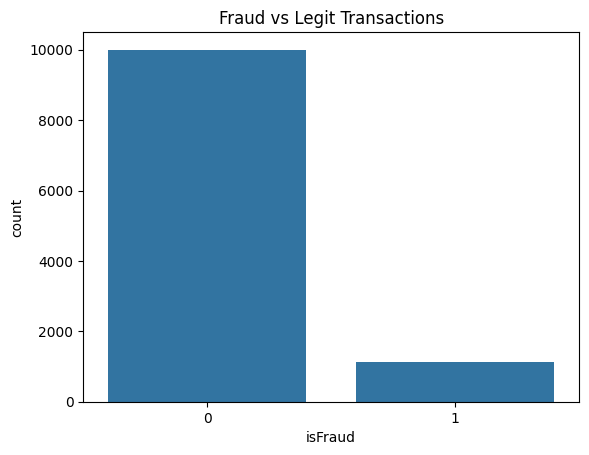

In [4]:
sns.countplot(data=df, x="isFraud")
plt.title("Fraud vs Legit Transactions")
plt.show()


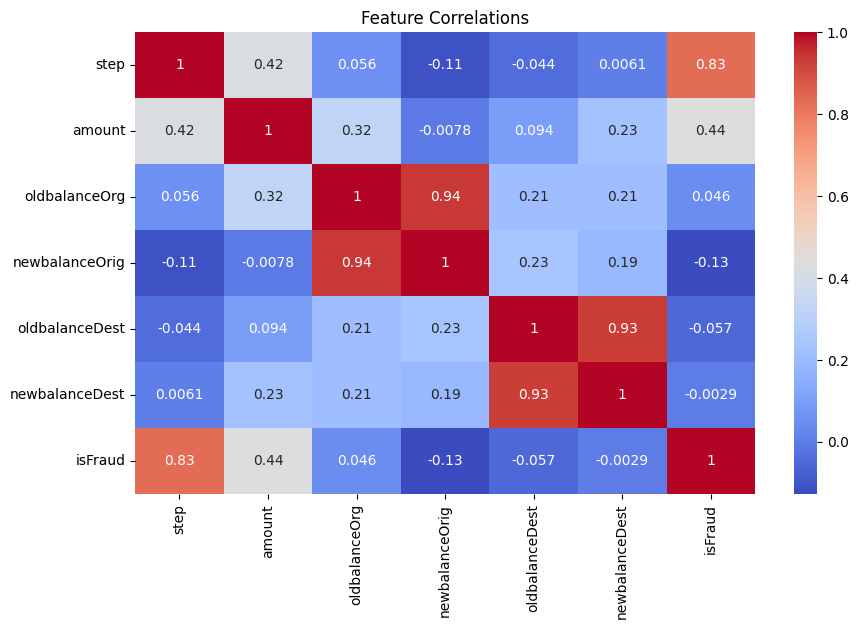

In [5]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()


In [6]:
# Recalculate error features (as done during training)
df["errorBalanceOrig"] = df["oldbalanceOrg"] - df["amount"] - df["newbalanceOrig"]
df["errorBalanceDest"] = df["newbalanceDest"] + df["amount"] - df["oldbalanceDest"]

# Encode 'type' as numeric codes
df['type'] = df['type'].astype('category').cat.codes

# Drop identifiers if present
df = df.drop(columns=[col for col in ["nameOrig", "nameDest"] if col in df.columns])

# Features and target split
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

# Ensure feature consistency
expected_cols = ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
                 'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrig', 'errorBalanceDest']
assert list(X.columns) == expected_cols, f"Column mismatch: {X.columns.tolist()}"

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load XGBoost model (trained with these features)
model = joblib.load("../models/XGBoost_model.pkl")

# Predict
y_pred = model.predict(X_test)


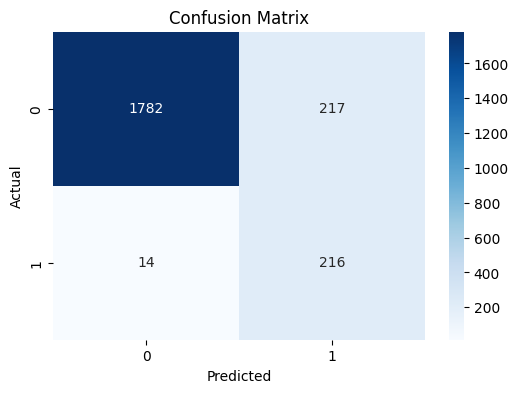

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Store for financial impact (next cell)
TP = cm[1][1]  # True Positives
FP = cm[0][1]  # False Positives


In [8]:
# 💰 Financial Impact Calculation

# Business assumptions
savings_per_fraud_txn = 500    # ₹ saved per correctly predicted fraud
cost_of_false_positive = 50    # ₹ lost when a legit transaction is wrongly flagged

# Financial outcome
estimated_savings = TP * savings_per_fraud_txn
estimated_loss = FP * cost_of_false_positive
net_impact = estimated_savings - estimated_loss

# Print results
print("🟢 Estimated Savings:", estimated_savings)
print("🔴 Estimated Loss:", estimated_loss)
print("💰 Net Financial Impact:", net_impact)


🟢 Estimated Savings: 108000
🔴 Estimated Loss: 10850
💰 Net Financial Impact: 97150


In [9]:
# 💰 Financial Impact Calculation

# Business assumptions
savings_per_fraud_txn = 500    # ₹ saved per correctly predicted fraud
cost_of_false_positive = 50    # ₹ lost when a legit transaction is wrongly flagged

# Financial outcome
estimated_savings = TP * savings_per_fraud_txn
estimated_loss = FP * cost_of_false_positive
net_impact = estimated_savings - estimated_loss

# Print results
print("🟢 Estimated Savings:", estimated_savings)
print("🔴 Estimated Loss:", estimated_loss)
print("💰 Net Financial Impact:", net_impact)


🟢 Estimated Savings: 108000
🔴 Estimated Loss: 10850
💰 Net Financial Impact: 97150


C:\Users\shrea\AppData\Local\Temp\ipykernel_8036\4082960089.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="viridis")


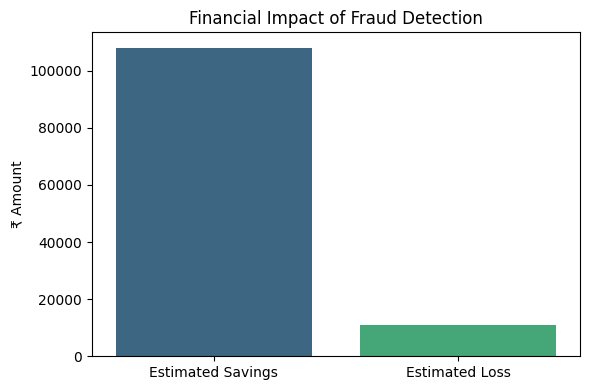

In [10]:
# 📊 Visualize Financial Outcome
plt.figure(figsize=(6, 4))
labels = ["Estimated Savings", "Estimated Loss"]
values = [estimated_savings, estimated_loss]

sns.barplot(x=labels, y=values, palette="viridis")
plt.title("Financial Impact of Fraud Detection")
plt.ylabel("₹ Amount")
plt.tight_layout()
plt.show()
